In [2]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt

reload()
# !pip install matplotlib-venn

In [3]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    for work in state.related - state.find("s0").related:
        backward |= (set(strategy.ref[work]) & state.related)
        forward |= (set(strategy.rev_ref[work]) & state.related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

### Snowballing - Busca via FS e BS no Artigo mais Citado (Seed Set = 1)

Não realiza busca em DL.
Realiza uma busca, via Forward e/ou via Backward para encontrar artigos do seed set no artigo mais citado, exemplo, mendes2004a.

### Forward

In [4]:
### Delta Related = Conector do nó
strategy = Strategy({work_by_varname("mendes2004a")})
strategy.forward().delta_related

{Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data}

In [5]:

{x.metakey for x in strategy.backward().visited}


{'briand1999a',
 'briand2000a',
 'christodoulou2000a',
 'cook1977a',
 'jeffery2000a',
 'jeffery2001a',
 'kemerer1987a',
 'kitchenham1984a',
 'kitchenham1998a',
 'kitchenham2001a',
 'kitchenham2004a',
 'maxwell2002a',
 'mendes2003a',
 'mendes2003b',
 'mendes2004a',
 'shepperd2001a',
 'wieczorek2002a',
 'wilcoxon1945a'}

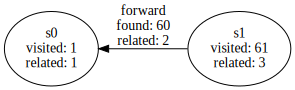

In [6]:
### Grafo
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.forward()

In [7]:
### Related do S1
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.forward().related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data}

### Backward

In [8]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward().delta_related

{A comparison of cross-company and within-company effort estimation models for web applications}

In [9]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward().visited

{Detection of influential observation in linear regression,
 What accuracy statistics really measure,
 Using simulation to evaluate prediction techniques,
 A replicated assessment of the use of adaptation rules to improve Web cost estimation,
 Software cost models,
 How valuable is company-specific data compared to multi-company data for software cost estimation?,
 Investigating early web size measures for web cost estimation,
 Assessment and comparison of common software cost estimation modeling techniques,
 Applied statistics for software managers,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 An empirical validation of software cost estimation models,
 A replicated assessment and comparison of common software cost modeling techniques,
 A comparison of cross-company and within-company effort estimatio

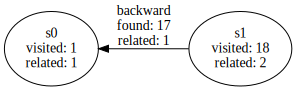

In [10]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward()

In [11]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward().name

's1'

### Snowballing - Forward and Backward - Union (N vezes)

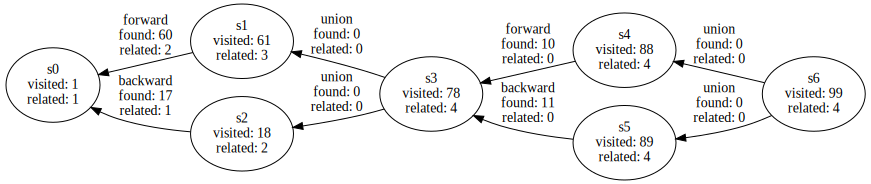

In [12]:
State.last_id = 0
state = strategy.sfbu()
state

In [114]:
separa_backward_forward(state) @ metakey_title


[['kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications'],
 ['premraj2007a - Building software cost estimation models using homogenous data']]

In [13]:
#Total de visitados = visitados no final - visitados no início
len(state.visited - state.find("s0").visited)

98

In [14]:
# Descrição dos Relacionados = relacionados no final - relacionados no início
state.related - state.find("s0").related

{A comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data}

In [15]:
#Encontrados no found - i.e., na iteração. Sem duplicados.
print("Relacionados:")
state.find("s5").delta_visited

Relacionados:


{Exploiting the essential assumptions of analogy-based effort estimation,
 How to find relevant data for effort estimation?,
 The need for web engineering: An introduction,
 Local vs. global models for effort estimation and defect prediction,
 Case studies for method and tool evaluation,
 On the relative value of cross-company and within-company data for defect prediction,
 Web cost estimation and productivity benchmarking,
 Software engineering metrics and models,
 A study of project selection and feature weighting for analogy based software cost estimation,
 Comparison of Web size measures for predicting Web design and authoring effort,
 Statistical power analysis for the behavioral sciences}

In [16]:
print("Relacionados:")
state.find("s5").delta_visited - state.find("s5").delta_visited

Relacionados:


set()

In [17]:
# Relacionados no Estado s4
state.find("s4").related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 A comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data}

In [18]:
# Found = 10, i.e., Visitados para chegar ao estado s4, sem incluir os duplicados - existentes na base.
print("Relacionados:")
state.find("s4").delta_visited

Relacionados:


{Effort estimation of web-based applications using machine learning techniques,
 An Empirical Analysis of Three-Stage Data-Preprocessing for Analogy-Based Software Effort Estimation on the ISBSG Data,
 From Function Points to COSMIC-A Transfer Learning Approach for Effort Estimation,
 Empirical Assessment of Machine Learning Models for Effort Estimation of Web-based Applications,
 Systematic literature review on effort estimation for Open Sources (OSS) web application development,
 Sharing data and models in software engineering,
 Mining app stores: Extracting technical, business and customer rating information for analysis and prediction,
 A comparison of cross-versus single-company effort prediction models for web projects,
 La práctica de la estimación en empresas y áreas de Sistemas,
 An empirical analysis of data preprocessing for machine learning-based software cost estimation}

In [19]:
print("Visitados:")
state.find("s0").visited

Visitados:


{Further comparison of cross-company and within-company effort estimation models for web applications}

In [20]:
#Visualização de Backward
#state.related & set(strategy.ref[work_by_varname("mendes2004a")])

state.find("s0").related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

## Estratégias

### Estratégia 1 - Busca em todas Digital Libraries (DL)

In [25]:
len ([x for _, x in load_work_map_all_years() if x.category == "snowball"])

4

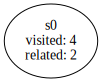

In [183]:
reload()
TOTAL = [x for _, x in load_work_map_all_years() if x.category == "snowball"]
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited

#strategy.initial.name
state


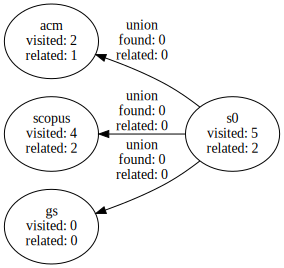

In [185]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["acm", "scopus", "gs"], filter_function)
#strategy.initial.find("acm")
strategy.initial

In [186]:
array = []

name = "E1"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E1
0.5
Recall E1
0.5


### Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

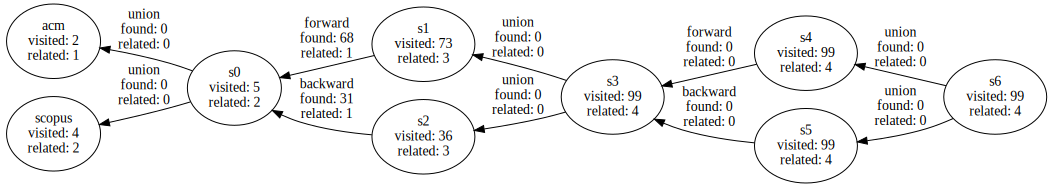

In [95]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

### Resumo 

#### Resumo da Busca em DL

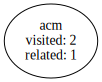

In [163]:
strategy.initial.find("acm")

In [164]:
# Visitados ACM
strategy.initial.find("acm").visited

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Cross-vs. within-company cost estimation studies revisited: an extended systematic review}

In [173]:
# Relacionados ACM - encontrado no seed set
strategy.initial.find("acm").related

{Further comparison of cross-company and within-company effort estimation models for web applications}

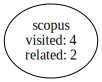

In [165]:
strategy.initial.find("scopus")

In [178]:
print("Visitados Scopus:")
strategy.initial.find("scopus").visited

Visitados Scopus:


{Further comparison of cross-company and within-company effort estimation models for web applications,
 Using public domain metrics to estimate software development effort,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data}

In [175]:
print("Relacionados Scopus - encontrado no seed set:")
strategy.initial.find("scopus").related

Relacionados Scopus - encontrado no seed set:


{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [179]:
print("Artigo comum a ACM e Scopus:")
strategy.initial.find("acm").visited & strategy.initial.find("scopus").visited

Artigo comum a ACM e Scopus:


{Further comparison of cross-company and within-company effort estimation models for web applications}

#### Resumo do Snowballing

In [180]:
#Total de visitados = visitados no final - visitados no início
print ("Total visitados:")
len(state.visited - state.find("s0").visited)

Total visitados:


94

In [112]:
# Descrição dos Relacionados = relacionados no final - relacionados no início
print ("Total Relacionados: Lista dos que foram encontrados via Snowballing")
state.related - state.find("s0").related

Total Relacionados: Lista dos que foram encontrados via Snowballing


{A comparison of cross-company and within-company effort estimation models for web applications,
 Building software cost estimation models using homogenous data}

In [146]:
print ("Encontrados via somente Snowballing:")
diff_related = state.related - state.find("s0").related
diff_related @ metakey_title

Encontrados via somente Snowballing:


['kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications',
 'premraj2007a - Building software cost estimation models using homogenous data']

### Detalhamento por Estado / Aresta

### Estado S0

#### Visitados

In [100]:
#S0 - Visitados
print("Visitados no Estado 0:")
state.find("s0").visited

Visitados no Estado 0:


{Web effort estimation: The value of cross-company data set compared to single-company data set,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 Using public domain metrics to estimate software development effort,
 Cross-vs. within-company cost estimation studies revisited: an extended systematic review}

#### Relacionados - Seed Set

In [132]:
#S0 - Relacionados - Encontrados via busca e que existem na lista dos Incluídos da SLR existente - são os seed set!
print("Relacionados no Estado 0: Seed Set")
state.find("s0").related @ metakey_title

Relacionados no Estado 0: Seed Set


['mendes2004a - Further comparison of cross-company and within-company effort estimation models for web applications',
 'ferrucci2012a - Web effort estimation: The value of cross-company data set compared to single-company data set']

### Aresta s0 -> s2 (Backward - Iteração 1)

In [153]:
# S2 - Backward (Found) - Visitados na iteração 1
print("Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_visited

Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:


{The need for web engineering: An introduction,
 A comparison of cross-company and within-company effort estimation models for web applications,
 Investigating early web size measures for web cost estimation,
 On the relative value of cross-company and within-company data for defect prediction,
 Software engineering metrics and models,
 Statistical power analysis for the behavioral sciences,
 When to use data from other projects for effort estimation,
 Exploiting the essential assumptions of analogy-based effort estimation,
 A replicated assessment of the use of adaptation rules to improve Web cost estimation,
 Case studies for method and tool evaluation,
 Using simulation to evaluate prediction techniques,
 A procedure for analyzing unbalanced datasets,
 Detection of influential observation in linear regression,
 Local vs. global models for effort estimation and defect prediction,
 Web cost estimation and productivity benchmarking,
 A replicated assessment and comparison of common sof

In [152]:
# S2 - Backward (Related) - Encontrados na iteração 1, via snowballing, que não foi encontrado via busca para o seed set.
print("Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_related @ metakey_title

Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:


['kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications']

### Aresta s0 -> s1 (Forward - Iteração 1)

In [151]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['premraj2007a - Building software cost estimation models using homogenous data']

### Relacionados - Encontrados Via Backward e Forward

In [128]:
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications'],
 ['premraj2007a - Building software cost estimation models using homogenous data']]

In [156]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [157]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['mendes2004a']
Forward ['mendes2004a', 'ferrucci2012a']


In [158]:
x = v.get_patch_by_id('100')

In [159]:
x.set_linestyle = "black"

In [142]:
#[x.metakey for x in state.find("s0").related]

### Execução de Backward (Aresta S0 -> S2) em cada artigo relacionado do S0

In [139]:
print("Descreve o S0 -> S2:\n Execução de Backward em cada artigo do related \n")
descreve_delta(strategy, state, "s2")

Descreve o S0 -> S2:
 Execução de Backward em cada artigo do related 

backward mendes2004a
- cook1977a 
- kitchenham2001a 
- mendes2003b 
- kitchenham1984a 
- wieczorek2002a 
- mendes2003a 
- briand1999a 
- maxwell2002a 
- christodoulou2000a 
- kemerer1987a 
- briand2000a 
- kitchenham2004a related
- wilcoxon1945a 
- shepperd2001a 
- kitchenham1998a 
forward mendes2004a
- kocaguneli2010a 
- kitchenham2007a 
- mendes2007a 
- mendes2008b 
- mendes2005b 
backward ferrucci2012a
- mendes2005a 
- kitchenham2004a related
- kitchenham2001a 
- mendes2003a 
- turhan2009a 
- conte1986a 
- kocaguneli2011a 
- cohen1988a 
- kocaguneli2010a 
- kocaguneli2012a 
- maxwell2002a 
- kitchenham1995a 
- mendes2008b 
- shepperd2001a 
- mendes2002a 
- kitchenham1998a 
- cook1977a 
- kitchenham2007a 
- mendes2007a 
- menzies2011a 
- mendes2008a 
- li2009a 
- mendes2005b 


### Execução de Forward em cada artigo relacionado do S1

In [141]:
print("Descreve o S0 -> S1:\n Execução de Forward em cada artigo do related \n")
descreve_delta(strategy, state, "s1")

Descreve o S0 -> S1:
 Execução de Forward em cada artigo do related 

forward mendes2004a
- mendes2007c 
- mendes2007d 
- watanabe2008a 
- ferrucci2015a 
- baresi2007a 
- costagliola2006a 
- ferrucci2008a 
- baker2010a 
- corazza2013a 
- wen2012a 
- ferrucci2009a 
- martino2016a 
- lang2009a 
- corazza2009a 
- keung2008b 
- lokan2008a 
- premraj2005a 
- martino2011a 
- abrahão2010a 
- ferrucci2010a 
- francese2015a 
- wieringa2015a 
- marco2012a 
- mendes2005c 
- matos2013a 
- shepperd2012a 
- al2006a 
- mittas2010b 
- martino2009a 
- huang2008a 
- corazza2011a 
- kitchenham2006a 
- kocaguneli2010a 
- keung2009a 
- buglione2010a 
- minku2015a 
- mair2005a 
- mittas2015a 
- mendes2008b 
- premraj2007a related
- mendes2007b 
- mendes2009b 
- lall2006a 
- mendes2008d 
- kitchenham2007a 
- azhar2013a 
- lokan2006a 
- mendes2007a 
- mittas2010a 
- keung2008a 
- marco2013a 
- mendes2009a 
- mendes2008e 
- costagliola2006b 
- zimmermann2009a 
- ferrucci2010b 
- mendes2005b 
- martino2007a 
ba

### Resumo do Precision e Recall

In [36]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision na Busca E2: 0.40%

Precision no Snowballing E2: 0.02%
Precision no Snowballing E2 - Forward - 1 iteração: 0.01%
Precision no Snowballing E2 - Backward - 1 iteração: 0.03%

Precision E2 (Busca + Snowballing): 0.04%
Precision E2
0.04040404040404041
Recall E2
1.0


### Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

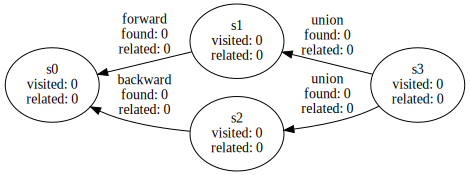

In [37]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [39]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E3


ZeroDivisionError: division by zero

### Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

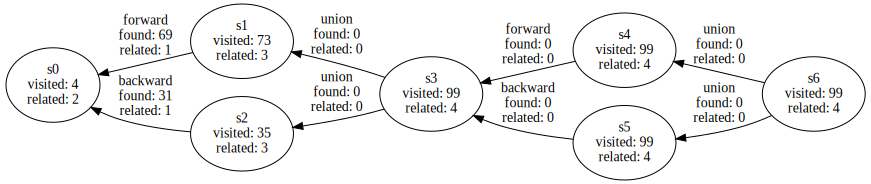

In [40]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.sfbu()
state

In [41]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E4
0.04040404040404041
Recall E4
1.0


In [42]:
state.find("s0").related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [43]:
state.find("s2").related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 A comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [44]:
state.find("s0").visited

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Using public domain metrics to estimate software development effort,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data}

In [45]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

{A comparison of cross-company and within-company effort estimation models for web applications}

In [46]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

{A comparison of cross-company and within-company effort estimation models for web applications}

In [47]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

{Building software cost estimation models using homogenous data}

In [48]:
len(state.find("s1").delta_visited)

69

In [49]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

60

In [50]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

17

In [51]:
search_state = strategy.initial
search_state.related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

### Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

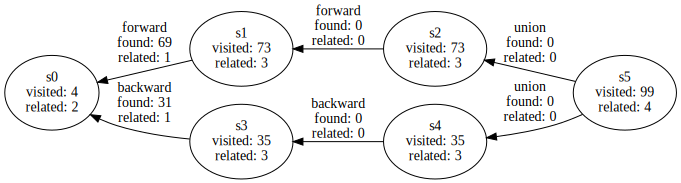

In [52]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [53]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E5
0.04040404040404041
Recall E5
1.0


In [54]:
state.find("s0").related 

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [55]:
state.find("s1").related 

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data}

In [56]:
state.find("s5").related 

{Web effort estimation: The value of cross-company data set compared to single-company data set,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 A comparison of cross-company and within-company effort estimation models for web applications,
 Building software cost estimation models using homogenous data}

In [57]:
sx, sy = state.previous[0]

sx.related & sy.related


{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [58]:
sx.name

's2'

In [59]:
sy.name

's4'

### Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

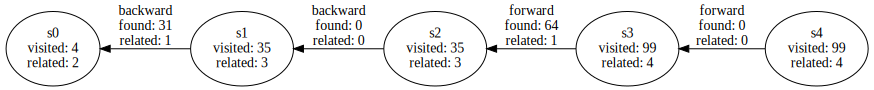

In [60]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [61]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E6
0.04040404040404041
Recall E6
1.0


### Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

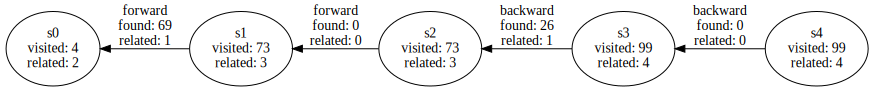

In [62]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [63]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E7
0.04040404040404041
Recall E7
1.0


### Análise das Estratégias

In [64]:
%matplotlib notebook
import pandas as pd

In [65]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall'])
df.index = df['Estratégia']
df

,Estratégia,Precision,Recall
Estratégia,,,
E1,E1,0.500000,0.5
E2,E2,0.040404,1.0
E4,E4,0.040404,1.0
E5,E5,0.040404,1.0
E6,E6,0.040404,1.0
E7,E7,0.040404,1.0


<IPython.core.display.Javascript object>


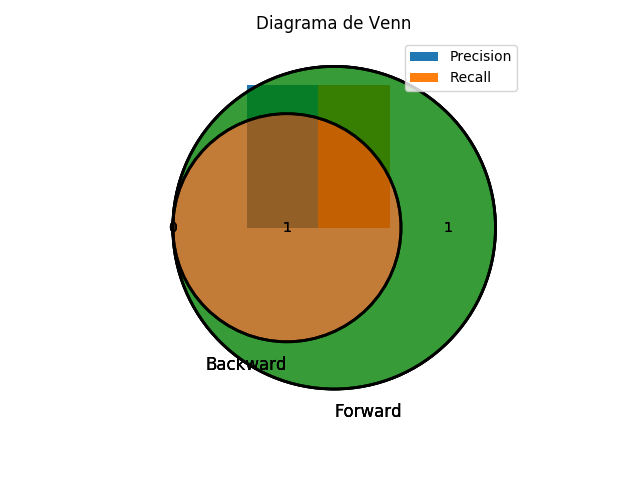

In [66]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


## Antigo

In [67]:

s5 = state.find("s5")
s5

In [68]:
s5.delta_related

AttributeError: 'NoneType' object has no attribute 'delta_related'

In [69]:
state.previous[0][1].previous[0][0].related

IndexError: list index out of range

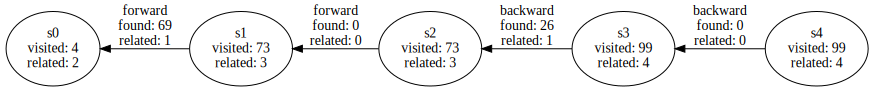

In [70]:
state

In [71]:
s1 = state.find("s1")
total = sum(1 for _, w in load_work_map_all_years() if w.category == "snowball")

In [72]:
len(s1.delta_related) / len(s1.delta_visited)

0.014492753623188406

In [73]:
len(s1.delta_related) / total

0.25

In [74]:
len(state.related) / len(state.visited)

0.04040404040404041

In [75]:
len(state.related) / total

1.0

In [76]:
state.log

deque([Step(name='start', new_references=4, new_related=2, total_visited=4, total_related=2, source='', target='s0'),
       Step(name='forward', new_references=69, new_related=1, total_visited=73, total_related=3, source='s0', target='s1'),
       Step(name='forward', new_references=0, new_related=0, total_visited=73, total_related=3, source='s1', target='s2'),
       Step(name='backward', new_references=26, new_related=1, total_visited=99, total_related=4, source='s2', target='s3'),
       Step(name='backward', new_references=0, new_related=0, total_visited=99, total_related=4, source='s3', target='s4')])

In [77]:
len(state.visited)

99

In [78]:
with open("output/snowballing.provn", "w") as provn:
    provn.write(state.provn)

In [79]:
!provconvert.bat -infile output/snowballing.provn -outfile output/snowballing.dot

In [80]:
with open("output/snowballing.dot", "r") as prov_dot:
    text = prov_dot.read().replace('rankdir="BT";', 'rankdir="RL"; ranksep="0.1";')
with open("output/snowballing.dot", "w") as prov_dot:
    prov_dot.write(text)

In [81]:
!dot -Tpng output/snowballing.dot -ooutput/snowballing.png
!dot -Tsvg output/snowballing.dot -ooutput/snowballing.svg
#!inkscape -D -z --file=output/snowballing.svg --export-pdf=output/snowballing.pdf

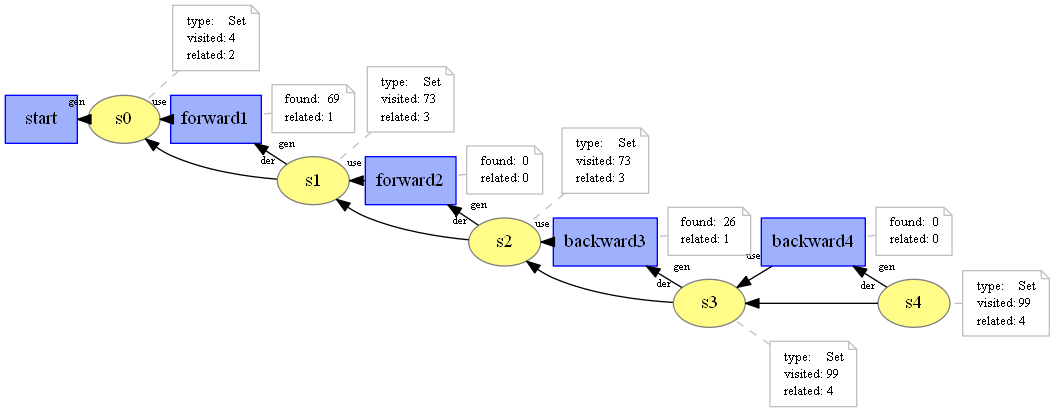

In [82]:
from IPython.display import Image
Image("output/snowballing.png")

In [83]:
log = state.log

In [84]:
len([x for _, x in load_work_map_all_years() if x.category in ('snowball','ok','backward')])

36

In [85]:
from fractions import Fraction
for step in log:
    print("precision", Fraction(step.new_related, step.new_references))

precision 1/2
precision 1/69


ZeroDivisionError: Fraction(0, 0)

In [ ]:
len([x for x in state.visited if x.category in {"snowball"}])

In [ ]:
from snowballing.approaches import get_approaches
len(get_approaches())

In [86]:
visited = state.visited
len([(x, x.year) for x in state.visited
     if x.category in {"nofile"}
     if x.place.name != "Tech Report"
     if x.place.name != "Book"
     if x.place.name != "Patent"
     if x.place.name == "Conference"
     if x.display != x.place.acronym
    ])
#count = 0
#for x in visited:
#     if hasattr(x, 'dglibrary'):
#        print(x.dglibrary)
#        count = 1 + count
#print (count)
len([
    (x, x.year) for x in visited
     if hasattr(x, 'dglibrary') and x.dglibrary=="Scopus"
    
])

def count_ref(library,obj):
    len_dglibrary = len([(x, x.year) for x in obj
                             if hasattr(x, 'dglibrary') and library in x.dglibrary  
                        ])
    len_backward = len([(x, x.year) for x in obj
                             if x.category=="backward"  
                        ])
    len_forward = len([(x, x.year) for x in obj
                             if x.category=="forward"  
                        ])
    qtdref=0
    qtdcitations=0
    for x in obj:
        qtdref=qtdref + int(getattr(x, "references", 0))
        
    scopus = sum(int(getattr(x, "scopus", 0)) for x in obj)
            
    for x in obj:
        qtdcitations=qtdcitations + int(getattr(x, "citations", 0))
    return len_dglibrary,qtdref,qtdcitations,len_backward,len_forward
     

print ("Digital Library, Referencias, Citações, Qtd Backward, Qtd Forward")
print(count_ref("Scopus",visited))

log

print (log[0].name, log[0].new_references)
print(log[1].name, log[1].new_references)
print(log[2].name, log[2].new_references)
print(log[3].name, log[3].new_references)
print("visitados", len(visited))

Digital Library, Referencias, Citações, Qtd Backward, Qtd Forward
(0, 0, 0, 0, 0)
start 4
forward 69
forward 0
backward 26
visitados 99


In [87]:
len([x for x in visited if x.category in {"lang"}])

0

In [88]:
len([x for x in visited if x.category in {"site"}])

0

In [89]:
len([x for x in visited
     if x.place.name == "Tech Report"
    ])

0

In [90]:
len([x for x in visited
     if x.place.name == "ESEM"
    ])

0

In [91]:
{x.category for x in visited}

{'ok', 'snowball', 'unrelated'}

In [92]:
[(x.year, x.authors, x.name, x.place.name, x.request) for x in visited
 if x.category in {"nofile"}
 if x.place.name != "Tech Report"
 if x.place.name != "Book"
 if x.place.name != "Patent"
 if x.display != x.place.acronym]

[]

In [ ]:
len(_)